## Importing libraries

In [1]:
#library 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, Lasso, Ridge 
from sklearn.metrics import r2_score
import statsmodels.api as sm
import warnings
import xlsxwriter
warnings.filterwarnings('ignore')

## Read the Master data file

In [2]:
data =pd.read_excel('../Data/100723_Fireball_Master_Data.xlsx')

## Feature engineering - Creating new vars from existing vars, transforming existing vars etc

In [3]:
## Use only these media variables (for media) and their adstock/lag/lead in the model
media_vars_list  = ['Digital_IMP_Channel_Internet_Display',
 'Digital_IMP_Channel_Mobile_App',
 'Digital_IMP_Channel_Mobile_Web_Video',
 'Digital_IMP_Channel_Mobile_Web',
 'Digital_IMP_Channel_Online_Video',
 'Digital_IMP_Channel_Paid_Social',
 'FB_Ecomm_Campaign_data']

In [4]:
## Adstock transformation function
def adstock(alpha, beta, var):
    new_var = var + "_transformed_" + str(alpha) +"_" + str(beta)
    data[new_var] = 0
    for i in range(len(data[var])):
        if i==0:
            data[new_var][i] = data[var][i]**alpha
        else:
            data[new_var][i] = (data[new_var][i-1]*beta+data[var][i])**alpha
            
## Create adstock variables for each of the media in media_vars_list
alphas_betas =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for var in media_vars_list:
    for alpha in alphas_betas:
        for beta in alphas_betas:
            #if alpha >= beta:
            data[var + '_adstock_' + str(alpha) + "_" + str(beta)] = adstock(alpha,beta,var)

In [5]:
## Get the seasonality from statsmodels time series seasonal decomposition
decomp = data[['Date','Dep_9L_Units_Sales']]
decomp.set_index('Date', inplace = True)
decomposition = seasonal_decompose(decomp['Dep_9L_Units_Sales'], model='multiplicative')
data['Seasonality'] = 0
data['Seasonality'] = np.array(decomposition.seasonal)

In [6]:
#Take lead/lag of media variables.

data['Digital_IMP_Channel_Internet_Display_lag_1'] = data['Digital_IMP_Channel_Internet_Display'].shift(1)
data['Digital_IMP_Channel_Internet_Display_lag_1'] = data['Digital_IMP_Channel_Internet_Display_lag_1'].fillna(0)

data['Digital_IMP_Channel_Mobile_Web_lag_1'] = data['Digital_IMP_Channel_Mobile_Web'].shift(1)
data['Digital_IMP_Channel_Mobile_Web_lag_1'] = data['Digital_IMP_Channel_Mobile_Web_lag_1'].fillna(0)

data['Digital_IMP_Channel_Mobile_Web_lag_2'] = data['Digital_IMP_Channel_Mobile_Web'].shift(2)
data['Digital_IMP_Channel_Mobile_Web_lag_2'] = data['Digital_IMP_Channel_Mobile_Web_lag_2'].fillna(0)

data['Digital_IMP_Channel_Mobile_Web_Video_lag_1'] = data['Digital_IMP_Channel_Mobile_Web_Video'].shift(1)
data['Digital_IMP_Channel_Mobile_Web_Video_lag_1'] = data['Digital_IMP_Channel_Mobile_Web_Video_lag_1'].fillna(0)


data['Digital_IMP_Channel_Mobile_App_lag_1'] = data['Digital_IMP_Channel_Mobile_App'].shift(1)
data['Digital_IMP_Channel_Mobile_App_lag_1'] = data['Digital_IMP_Channel_Mobile_App_lag_1'].fillna(0)

data['Digital_IMP_Channel_Mobile_App_lag_2'] = data['Digital_IMP_Channel_Mobile_App'].shift(2)
data['Digital_IMP_Channel_Mobile_App_lag_2'] = data['Digital_IMP_Channel_Mobile_App_lag_2'].fillna(0)

In [7]:
data['TV_Spends_Channel_avod_cableTV']=data['TV_Spends_Channel_AVOD'] + data['TV_Spends_Channel_Cable_TV']

In [8]:
data['TV_Spends_Channel_avod_cableTV_lag_1'] = data['TV_Spends_Channel_avod_cableTV'].shift(1)
data['TV_Spends_Channel_avod_cableTV_lag_1'] = data['TV_Spends_Channel_avod_cableTV_lag_1'].fillna(0)

data['TV_Spends_Channel_avod_cableTV_lag_2'] = data['TV_Spends_Channel_avod_cableTV'].shift(2)
data['TV_Spends_Channel_avod_cableTV_lag_2'] = data['TV_Spends_Channel_avod_cableTV_lag_2'].fillna(0)

data['TV_Spends_Channel_Cable_TV_lag_1'] = data['TV_Spends_Channel_Cable_TV'].shift(1)
data['TV_Spends_Channel_Cable_TV_lag_1'] = data['TV_Spends_Channel_Cable_TV_lag_1'].fillna(0)

data['TV_Spends_Channel_Cable_TV_lag_2'] = data['TV_Spends_Channel_Cable_TV'].shift(2)
data['TV_Spends_Channel_Cable_TV_lag_2'] = data['TV_Spends_Channel_Cable_TV_lag_2'].fillna(0)

data['TV_Spends_Channel_AVOD_lag_1'] = data['TV_Spends_Channel_AVOD'].shift(1)
data['TV_Spends_Channel_AVOD_lag_1'] = data['TV_Spends_Channel_AVOD_lag_1'].fillna(0)

data['TV_Spends_Channel_AVOD_lag_2'] = data['TV_Spends_Channel_AVOD'].shift(2)
data['TV_Spends_Channel_AVOD_lag_2'] = data['TV_Spends_Channel_AVOD_lag_2'].fillna(0)

data['Digital_IMP_Channel_Online_Video_lag_1'] = data['Digital_IMP_Channel_Online_Video'].shift(1)
data['Digital_IMP_Channel_Online_Video_lag_1'] = data['Digital_IMP_Channel_Online_Video_lag_1'].fillna(0)

data['Digital_IMP_Channel_Online_Video_lag_2'] = data['Digital_IMP_Channel_Online_Video'].shift(2)
data['Digital_IMP_Channel_Online_Video_lag_2'] = data['Digital_IMP_Channel_Online_Video_lag_2'].fillna(0)

data['Digital_IMP_Channel_Paid_Social_lag_1'] = data['Digital_IMP_Channel_Paid_Social'].shift(1)
data['Digital_IMP_Channel_Paid_Social_lag_1'] = data['Digital_IMP_Channel_Paid_Social_lag_1'].fillna(0)

data['Digital_IMP_Channel_Paid_Social_lag_2'] = data['Digital_IMP_Channel_Paid_Social'].shift(2)
data['Digital_IMP_Channel_Paid_Social_lag_2'] = data['Digital_IMP_Channel_Paid_Social_lag_2'].fillna(0)

#lead

data['Digital_IMP_Channel_Online_Video_lead_1'] = data['Digital_IMP_Channel_Online_Video'].shift(-1)
data['Digital_IMP_Channel_Online_Video_lead_1'] = data['Digital_IMP_Channel_Online_Video_lead_1'].fillna(0)

data['Digital_IMP_Channel_Online_Video_lead_2'] = data['Digital_IMP_Channel_Online_Video'].shift(-2)
data['Digital_IMP_Channel_Online_Video_lead_2'] = data['Digital_IMP_Channel_Online_Video_lead_2'].fillna(0)


data['Digital_IMP_Channel_Paid_Social_lead_1'] = data['Digital_IMP_Channel_Paid_Social'].shift(-1)
data['Digital_IMP_Channel_Paid_Social_lead_1'] = data['Digital_IMP_Channel_Paid_Social_lead_1'].fillna(0)


data['Digital_IMP_Channel_Paid_Social_lead_2'] = data['Digital_IMP_Channel_Paid_Social'].shift(-2)
data['Digital_IMP_Channel_Paid_Social_lead_2'] = data['Digital_IMP_Channel_Paid_Social_lead_2'].fillna(0)


data['Digital_IMP_Channel_Mobile_App_lead_1'] = data['Digital_IMP_Channel_Mobile_App'].shift(-1)
data['Digital_IMP_Channel_Mobile_App_lead_1'] = data['Digital_IMP_Channel_Mobile_App_lead_1'].fillna(0)

data['Digital_IMP_Channel_Mobile_App_lead_2'] = data['Digital_IMP_Channel_Mobile_App'].shift(-2)
data['Digital_IMP_Channel_Mobile_App_lead_2'] = data['Digital_IMP_Channel_Mobile_App_lead_2'].fillna(0)

data['FB_Ecomm_Campaign_data_lead_1'] = data['FB_Ecomm_Campaign_data'].shift(-1)
data['FB_Ecomm_Campaign_data_lead_1'] = data['FB_Ecomm_Campaign_data_lead_1'].fillna(0)

data['FB_Ecomm_Campaign_data_lead_2'] = data['FB_Ecomm_Campaign_data'].shift(-2)
data['FB_Ecomm_Campaign_data_lead_2'] = data['FB_Ecomm_Campaign_data_lead_2'].fillna(0)

## Check correlation of the independant vars with the dependant var

In [9]:
x_corr=data[['Dep_9L_Units_Sales',
        'Avg_Price',
       'TV_Spends_Channel_AVOD', 
       'TV_Spends_Channel_Cable_TV',
       #'TV_Spends_Channel_avod_cableTV',
       'Digital_IMP_Channel_Internet_Display',
       'Digital_IMP_Channel_Mobile_App',
       'Digital_IMP_Channel_Mobile_Web_Video',
       'Digital_IMP_Channel_Mobile_Web',
       'Digital_IMP_Channel_Online_Video',
       'Digital_IMP_Channel_Paid_Social',
       'Seasonality',
       #'stringency_index',
       'FB_Ecomm_Campaign_data',
       'Innovation_on_Time',
       'Percentage_HHP_by_Numerator',
       #'Total_No_of_Innovation',
       #'Miss_Innovation',
       #'Percentage_of_Successful_Innovations',
       'HHP_whiskey_Percentage',
       'HHP_whiskey_BUY_Rate',
       'HHP_whiskey_PUR_Freq'
       #'HHP_Liquor_Percentage', 
       #'HHP_Liquor_BUY_Rate',
       #'HHP_Liquor_PUR_Freq'
       ]].corr()
x_corr['Dep_9L_Units_Sales']

Dep_9L_Units_Sales                      1.000000
Avg_Price                              -0.130571
TV_Spends_Channel_AVOD                  0.516251
TV_Spends_Channel_Cable_TV              0.163569
Digital_IMP_Channel_Internet_Display    0.124401
Digital_IMP_Channel_Mobile_App          0.009361
Digital_IMP_Channel_Mobile_Web_Video    0.395615
Digital_IMP_Channel_Mobile_Web         -0.159963
Digital_IMP_Channel_Online_Video        0.524648
Digital_IMP_Channel_Paid_Social         0.286587
Seasonality                             0.638254
FB_Ecomm_Campaign_data                  0.707813
Innovation_on_Time                     -0.050786
Percentage_HHP_by_Numerator             0.721939
HHP_whiskey_Percentage                  0.653429
HHP_whiskey_BUY_Rate                   -0.260518
HHP_whiskey_PUR_Freq                   -0.345531
Name: Dep_9L_Units_Sales, dtype: float64

#### Use a heatmap to better visualize of the correlations

<Axes: >

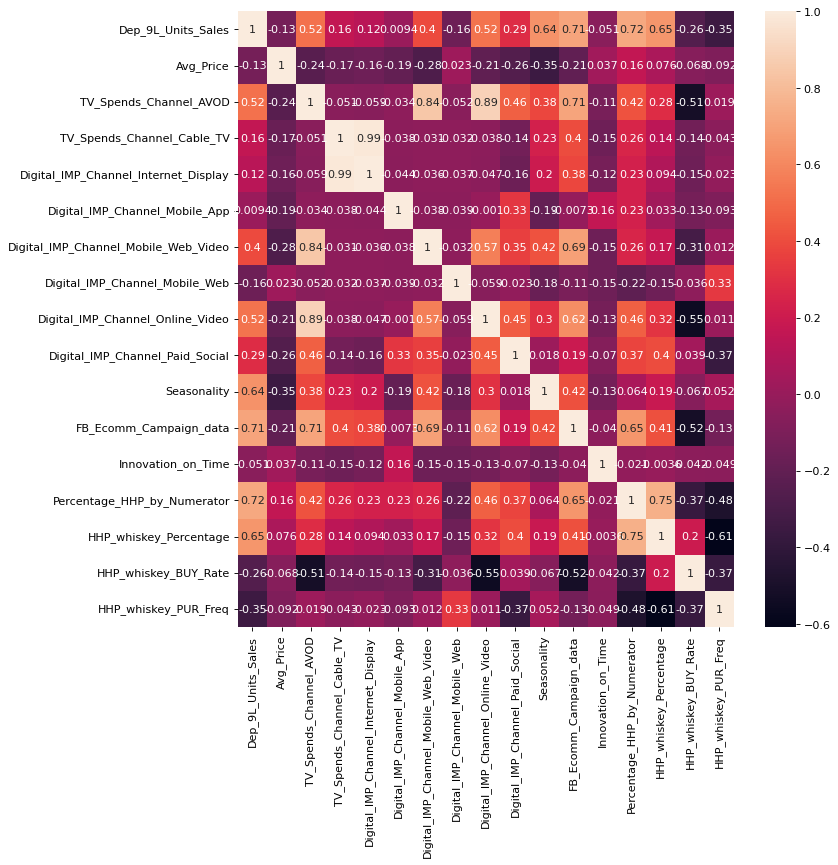

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)
sns.heatmap(x_corr, annot = True)

## Running OLS

In [11]:
### Assign the dependent variable to a variable y
y = data['Dep_9L_Units_Sales']

In [12]:
### Subset the independent variables that needs to be fed into the model. 
### You can try adstocked variables for each of the media vars and check if you can improve the model fit

X=data[['Avg_Price',
       #'TV_Spends_Channel_AVOD', 
       #'TV_Spends_Channel_Cable_TV',
       #'TV_Spends_Channel_avod_cableTV',
       #'Digital_IMP_Channel_Internet_Display',
       'Digital_IMP_Channel_Mobile_App_lag_1',
       #'Digital_IMP_Channel_Mobile_Web_Video',
       #'Digital_IMP_Channel_Mobile_Web',
       #'Digital_IMP_Channel_Online_Video_lead_1',
       'Digital_IMP_Channel_Paid_Social',
       'Seasonality',
       #'stringency_index',
       'FB_Ecomm_Campaign_data_lead_1',
       'Innovation_on_Time',
       'Percentage_HHP_by_Numerator',
       #'Total_No_of_Innovation',
       #'Miss_Innovation',
       #'Percentage_of_Successful_Innovations',
       #'HHP_whiskey_Percentage',
       #'HHP_whiskey_BUY_Rate',
       #'HHP_whiskey_PUR_Freq',
       #'HHP_Liquor_Percentage', 
       #'HHP_Liquor_BUY_Rate',
       #'HHP_Liquor_PUR_Freq',
       #'Flag_Aug_21_&_22',
       #'Flag_Apr_22',
       #'Flag_May_22',
       #'Flag_Jun_22'
       ]]

In [13]:
#importing model
import statsmodels.api as sm
#X = sm.add_constant(X) ## Uncomment this
lr = sm.OLS(y, X).fit() ## Fit the model


In [14]:
## Calculate VIF. 
## VIF is a measure of multicollinearity in the model. Ideally, should be <5 for each variable
vif = pd.DataFrame()
vif["var"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,var,VIF
0,Avg_Price,74.710110
1,Digital_IMP_Channel_Mobile_App_lag_1,1.358598
2,Digital_IMP_Channel_Paid_Social,3.105886
3,Seasonality,161.379400
4,FB_Ecomm_Campaign_data_lead_1,1.688925
5,Innovation_on_Time,1.902971
6,Percentage_HHP_by_Numerator,364.846349


In [15]:
## Model summary
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Dep_9L_Units_Sales   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1050.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                    3.22e-30
Time:                        13:09:36   Log-Likelihood:                         -290.95
No. Observations:                  33   AIC:                                      595.9
Df Residuals:                      26   BIC:                                      606.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Avg_Price                              -18.3796     25.738     -0.714      0.482     -71.285      34.525
Digital_IMP_Channel_Mobile_App_lag_1     0.0010      0.001      1.724      0.097      -0.000       0.002
Digital_IMP_Channel_Paid_Social       7.033e-05   4.86e-05      1.447      0.160   -2.96e-05       0.000
Seasonality                           2.085e+04   4049.317      5.148      0.000    1.25e+04    2.92e+04
FB_Ecomm_Campaign_data_lead_1            0.1249      0.028      4.458      0.000       0.067       0.183
Innovation_on_Time                     285.7220    305.400      0.936      0.358    -342.037     913.481
Percentage_HHP_by_Numerator            9.35e+04   8.85e+04      1.056      0.301   -8.85e+04    2.75e+05
==============================================================================
Omnibus:                        0.265   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.876   Jarque-Bera (JB):                0.419
Skew:                          -0.173   Prob(JB):                        0.811
Kurtosis:                       2.570   Cond. No.                     3.21e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.21e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
## Calculate MAPE : Ideally should be less than 5
mape = mean_absolute_percentage_error(y,lr.predict(X))*100
f"MAPE is : {round(mape,2)}"

'MAPE is : 4.95'

### Good model:
 The adj R2 > 80%  and MAPE < 5<br/>
All the coefficients should have the correct directionality (ex : Avg Price coeff should be negative, media var coeffs should be                positive etc)<br/>
The VIF < 5 for each variable
### If you get a good model fit that satisfies the above criteria, proceed and write the results to excel

## Write to excel

In [17]:
## Folder name and file name of the excel file - The file name needs to be changed everytime you write a result to excel
results_directory = 'Results_Demo'
results_file = 'results_iter.xlsx'

## No need to edit anything below. Just the run the below cells and it will create an excel file with the model output

In [18]:
y =data['Dep_9L_Units_Sales']

In [19]:
dv =['Dep_9L_Units_Sales']
results_directory = 'Results_Demo'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

In [20]:
writer = pd.ExcelWriter(results_directory + "/"  + results_file,engine='xlsxwriter')   
workbook = writer.book

In [21]:
worksheet=workbook.add_worksheet('Input Data')
writer.sheets['Input Data'] = worksheet

In [22]:
results = lr.summary2()
df_coeff = results.tables[1].reset_index()
df_coeff.rename(columns = {'index':'Variable'}, inplace=True)
var_list = list(df_coeff['Variable'].unique())
try:
    var_list.remove('const')
except:
    pass
last_row = 0
df_raw = data[ ['Date'] + var_list + dv]
df_raw.to_excel(writer,sheet_name='Input Data',startrow=last_row , startcol=1, index = False)

In [23]:
worksheet = workbook.add_worksheet('Model Results')
writer.sheets['Model Results'] = worksheet

In [24]:
last_row = 0
last_col = 1
df_coeff = results.tables[1]
df_coeff = df_coeff.reset_index()
df_coeff.rename(columns = {'index':'Variable'}, inplace=True)
pd.DataFrame(columns = ['Model results']).to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)
last_row += 1
df_coeff.to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)  
last_row = results.tables[1].shape[0] + last_row + 2
last_col = results.tables[1].shape[1] + last_col + 2

In [25]:
pd.DataFrame(columns = ['Model Evaluation Metrics']).to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)
last_row += 1
y_pred = lr.predict(X)
mape = mean_absolute_percentage_error(y,y_pred)
model_metrics = pd.DataFrame(data = {'Evaluation Metric':['R2', 'Adj R2', 'MAPE' ], 
                                     'Value':[lr.rsquared, lr.rsquared_adj, mape]})
model_metrics.to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)  
last_row = model_metrics.shape[0] + last_row + 2
last_col = model_metrics.shape[1] + last_col + 2

#### elasticity of a variable = coeffcient of variable * avg(variable)/avg(dependent variable)

In [26]:
pd.DataFrame(columns = ['Elasticities']).to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)
last_row += 1
df_elasticities = X.mean(axis=0).reset_index()
df_elasticities.columns = ['Variable','mean_val']
df_elasticities = df_elasticities[df_elasticities['Variable'] != 'const'] 
df_elasticities = df_elasticities.merge(df_coeff[['Variable','Coef.']], on = 'Variable', how = 'left')
df_elasticities['Elasticity'] = df_elasticities['mean_val']*df_elasticities['Coef.']/y.mean()
df_elasticities = df_elasticities[['Variable','Elasticity']]
df_elasticities.to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False) 
last_row = df_elasticities.shape[0] + last_row + 2
last_col = df_elasticities.shape[1] + last_col + 2

In [27]:
var_list = list(df_coeff['Variable'].unique())
try:
    var_list.remove('const')
except:
    pass
df_raw = data[['MAT'] +  var_list + dv]
df_raw = df_raw.groupby('MAT').sum()
df_raw = df_raw.transpose().reset_index()
df_raw.columns = ['Variable','MAT-21','MAT-22','MAT-23']
df_raw.drop('MAT-21',axis=1,inplace=True)
df_raw = df_raw.merge(df_coeff[['Variable','Coef.']], on = 'Variable', how = 'left')
df_raw['Contribution_MAT-22'] = df_raw['Coef.'] * df_raw['MAT-22']
df_raw['Contribution_MAT-23'] = df_raw['Coef.'] * df_raw['MAT-23']

In [28]:
sales_MAT_22 = df_raw[df_raw['Variable'] == dv[0]]['MAT-22'].values[0]
sales_MAT_23 = df_raw[df_raw['Variable'] == dv[0]]['MAT-23'].values[0]

df_raw['Due_to'] = (df_raw['Contribution_MAT-23'] - df_raw['Contribution_MAT-22'])/sales_MAT_22
df_raw = df_raw[['Variable', 'Contribution_MAT-22','Contribution_MAT-23', 'Due_to']]
df_raw = df_raw.iloc[:-1]

In [29]:
total_contrib = df_raw['Due_to'].sum()

In [30]:
df_raw = pd.concat([df_raw,
                    pd.DataFrame([{'Variable':"", 'Contribution_MAT-22':"",
                                  'Contribution_MAT-23':"", 'Due_to':""}])],
                   ignore_index = True)

df_raw = pd.concat([df_raw,
                    pd.DataFrame([{'Variable':dv[0], 'Contribution_MAT-22':sales_MAT_22,
                                  'Contribution_MAT-23':sales_MAT_23, 'Due_to':sales_MAT_23/sales_MAT_22 - 1}])],
                   ignore_index = True)

In [31]:
df_temp = data[['MAT']]
df_temp['Pred'] = y_pred
sales_MAT_21_pred, sales_MAT_22_pred, sales_MAT_23_pred = df_temp.groupby('MAT').sum()['Pred'].values

In [32]:
df_raw = pd.concat([df_raw,
                    pd.DataFrame([{'Variable':dv[0]+'_Predicted', 'Contribution_MAT-22':sales_MAT_22_pred,
                                  'Contribution_MAT-23':sales_MAT_23_pred, 'Due_to':total_contrib}])],
                   ignore_index = True)

df_raw = pd.concat([df_raw,
                    pd.DataFrame([{'Variable':'Unexplained', 'Contribution_MAT-22':abs(sales_MAT_22 - sales_MAT_22_pred),
                                  'Contribution_MAT-23':abs(sales_MAT_23 - sales_MAT_23_pred), 
                                   'Due_to':df_raw.iloc[-2]['Due_to'] -df_raw.iloc[-1]['Due_to']}])],
                   ignore_index = True)

In [33]:
pd.DataFrame(columns = ["Contributions"]).to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)
last_row += 1
df_raw.to_excel(writer,sheet_name='Model Results',startrow=last_row , startcol=1, index = False)  

In [34]:
worksheet=workbook.add_worksheet('Actual vs Predicted')
writer.sheets['Actual vs Predicted'] = worksheet

In [35]:
last_row = 0
last_col = 1
df_raw = data[['MAT','Date',dv[0]]]
df_raw[dv[0]+"_pred"] = y_pred
df_raw.rename(columns = {dv[0]:dv[0]+'_actual'}, inplace= True)
pd.DataFrame(columns = ['Actual vs Predicted']).to_excel(writer,sheet_name='Actual vs Predicted',startrow=last_row , startcol=1, index = False)
last_row += 1
df_raw.to_excel(writer,sheet_name='Actual vs Predicted',startrow=last_row , startcol=1, index = False)  
last_row = results.tables[1].shape[0] + last_row + 2
last_col = results.tables[1].shape[1] + last_col + 2

In [36]:
writer.close()
writer.handles = None

### Actual vs Predicted sales

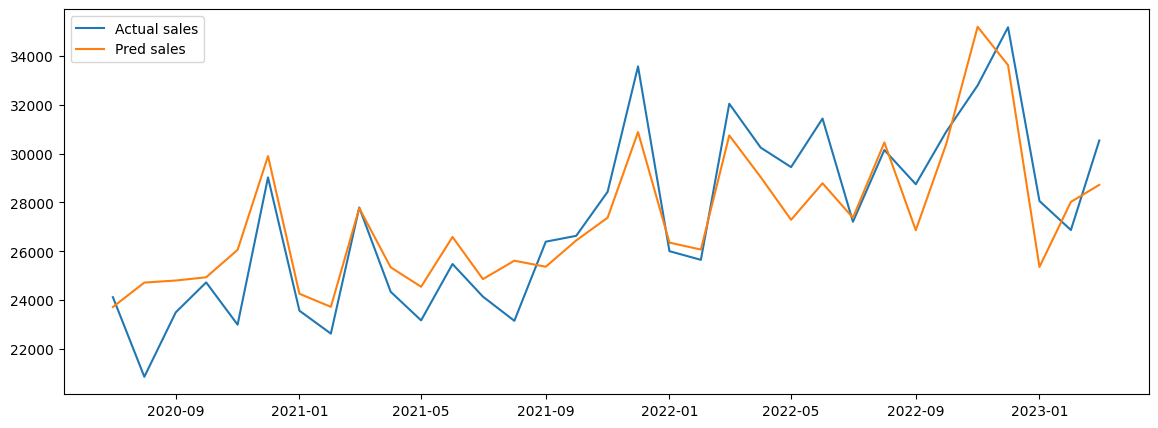

In [37]:
df_pred = data[['Date','Dep_9L_Units_Sales']]
df_pred['Sales_pred'] = lr.predict(X)
plt.figure(figsize=(14,5))
plt.plot(df_pred['Date'], df_pred['Dep_9L_Units_Sales'], label = 'Actual sales')
plt.plot(df_pred['Date'], df_pred['Sales_pred'], label = 'Pred sales')
plt.legend()
plt.show();